# Практическое задание №1

## Прогнозирование продаж сети магазинов Эквадора с помощью эконометрических моделей

**Выполнили:** Кирякин Максим, Куренкова Дарья, Коваль Наталья

**Источник данные:** https://www.kaggle.com/c/store-sales-time-series-forecasting/data

### Постановка задачи

Требуется предсказать с помощью эконометрической модели число продаж в сети магазинов Эквадора, на основе данных о продаже за год.


### Подготовка среды

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from hyperopt.fmin import fmin
from hyperopt.pyll import scope
from hyperopt import hp, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

from Utils.graphs import *

### Загрузка и обработка данных

**train.csv**

Обучающие данные, состоящие из временных рядов -- признаков: `store_nbr`, `family` и `onpromotion`, а также целевых продаж.

Описание значений переменных:
- `store_nbr` идентифицирует магазин, в котором продаются товары.  
- `family` определяет тип продаваемого продукта.  
- `sales` указывает общую сумму продаж для определенной группы товаров в конкретном магазине на заданную дату. Возможны дробные значения, так как товары могут продаваться в дробных единицах (например, 1,5 кг сыра вместо 1 пакета чипсов).  
- `onpromotion` указывает общее количество товаров в группе продуктов, которые были на акции в магазине на заданную дату.

**stores.csv**

Метаданные магазинов, включая город, штат, тип и кластер.  
Кластер — это группа схожих магазинов.

**oil.csv**

Ежедневные цены на нефть. Включает значения как в период обучения, так и в период тестирования. (Эквадор — страна, зависимая от нефти, и ее экономическое состояние сильно подвержено колебаниям цен на нефть.)


In [2]:
labels = {
    "store_nbr": "id магазина",
    "sales": "Число продаж",
    "onpromotion": "Число акций",
    "dcoilwtico": "Цена топлива",
    "transactions": "Число транзакций",
    "city": "Страна",
    "cluster": "Группа"
}

In [3]:
data = [
    "holidays_events.csv",
    "oil.csv",
    "stores.csv",
    "train.csv",
    "transactions.csv"
]

leftDate, rightDate = '2016-01-01', '2017-01-01'
dataframes = {}

for file in data:
    name = file.split(".")[0]
    dataframes[name] = pd.read_csv("Data\\" + file)

dataframes["trainTotal"] = (
    dataframes["train"]
    .merge(dataframes["holidays_events"].drop_duplicates("date"), on="date", how="left")
    .merge(dataframes["oil"].drop_duplicates("date"), on="date", how="left")
    .merge(dataframes["transactions"], on=["date", "store_nbr"], how="left")
    .merge(dataframes["stores"].drop_duplicates("store_nbr"), on="store_nbr", how="left")
    .rename(columns = {'type_x' : "holiday_type", "type_y" : "store_type"})
)
assert dataframes["trainTotal"].shape[0] == dataframes["train"].shape[0]

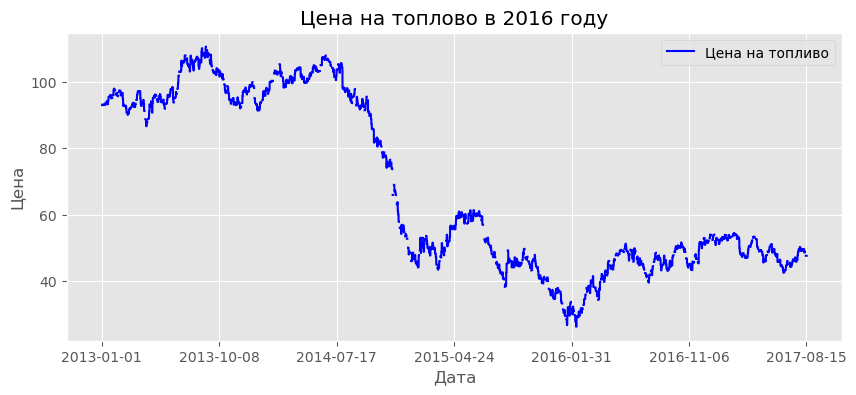

In [4]:
(
    dataframes["trainTotal"][["date", "dcoilwtico"]]
    .set_index("date")
    .rename(columns={"dcoilwtico": "Цена на топливо"})
    .plot(figsize=(10, 4), color="blue")
)
plt.title('Цена на топлово в 2016 году'), plt.xlabel('Дата'), plt.ylabel('Цена');

In [5]:
dataframes["trainTotal"]['dcoilwtico'] = (
    dataframes["trainTotal"]['dcoilwtico']
    .interpolate(method='polynomial', order=2)
)

dataframes["trainTotal"]['transactions'] = (
    dataframes["trainTotal"]['transactions']
    .fillna(dataframes["trainTotal"]['transactions'].mean())
)

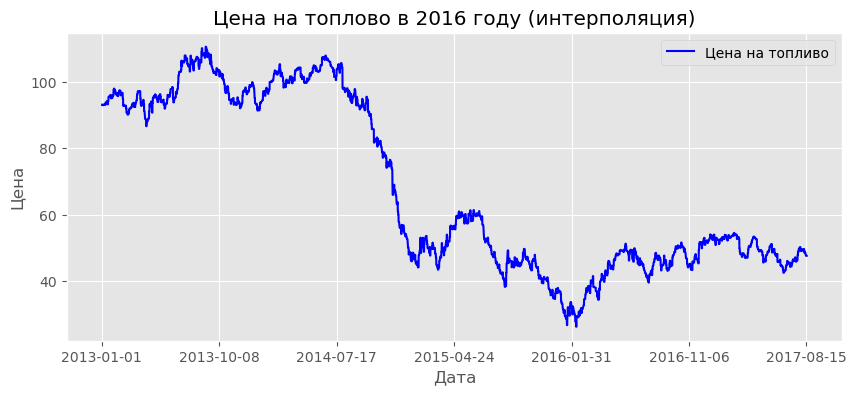

In [6]:
(
    dataframes["trainTotal"][["date", "dcoilwtico"]]
    .set_index("date")
    .rename(columns={"dcoilwtico": "Цена на топливо"})
    .plot(figsize=(10, 4), color="blue")
)
plt.title('Цена на топлово в 2016 году (интерполяция)'), plt.xlabel('Дата'), plt.ylabel('Цена');

In [7]:
dataframes["trainTotal"] = dataframes["trainTotal"].query("(date >= @leftDate) & (date < @rightDate)")

In [8]:
size = dataframes["trainTotal"].shape[0]
(
    pd.DataFrame(dataframes["trainTotal"].isna().sum()).reset_index().rename(columns={"index":"column", 0: "missing"})
    .eval("share=missing/@size")
    .query("missing > 0")
)

,column,missing,share
6,holiday_type,518562,0.79726
7,locale,518562,0.79726
8,locale_name,518562,0.79726
9,description,518562,0.79726
10,transferred,518562,0.79726


In [9]:
dataframes["trainTotal"] = (
    dataframes["trainTotal"]
    .drop(columns=["holiday_type", "locale", "locale_name", "description", "transferred"])
)

In [10]:
size = dataframes["trainTotal"].shape[0]
(
    pd.DataFrame(dataframes["trainTotal"].isna().sum()).reset_index().rename(columns={"index":"column", 0: "missing"})
    .eval("share=missing/@size")
    .query("missing > 0")
)

,column,missing,share


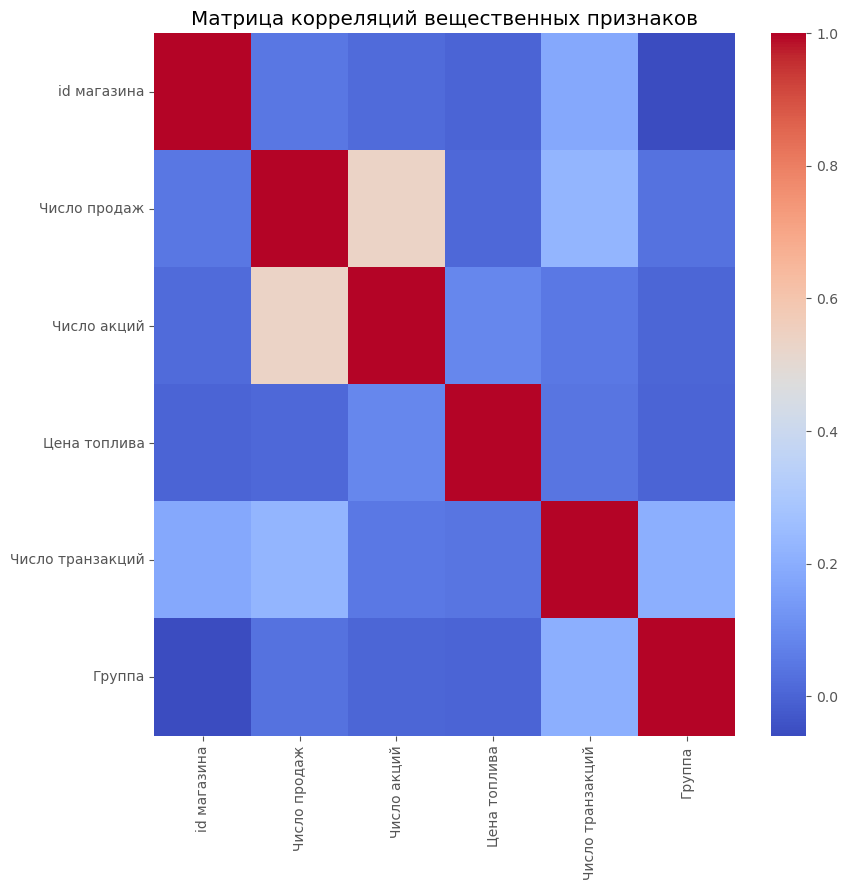

In [11]:
fig, ax = plt.subplots(figsize=(9, 9))
numColsToDrop = list(dataframes["trainTotal"].select_dtypes(exclude=[np.number]).columns) + ["id"]
data = dataframes["trainTotal"].drop(columns=numColsToDrop).rename(columns=labels)

corr = data.corr()

sns.heatmap(corr, cmap="coolwarm", ax = ax)
ax.set_title("Матрица корреляций вещественных признаков")
plt.tight_layout(), plt.show();

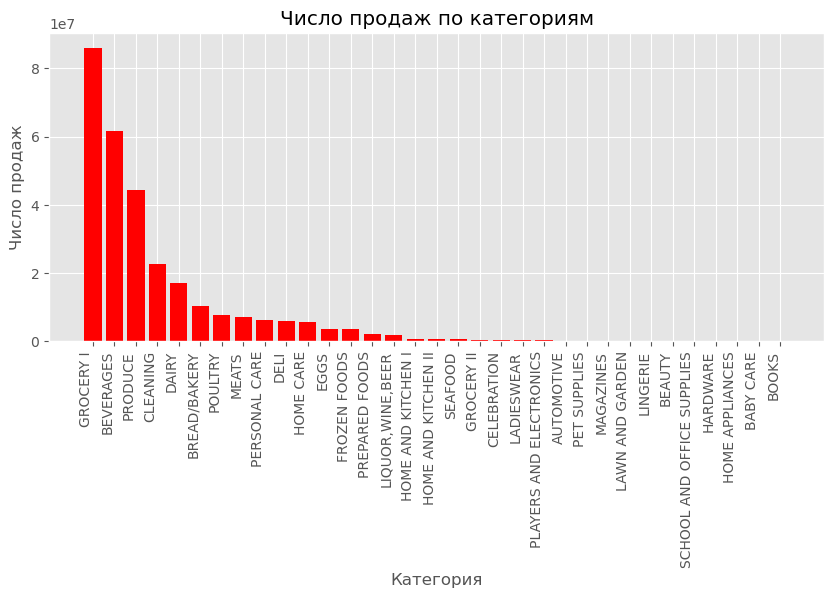

In [12]:
plt.figure(figsize=(10, 4))
data = (
    dataframes["trainTotal"]
    .groupby('family')['sales']
    .sum()
    .reset_index()
    .sort_values(by='sales', ascending=False)
)

plt.bar(data['family'], data['sales'], color='red')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Adding titles and labels for clarity
plt.title('Число продаж по категориям')
plt.xlabel('Категория')
plt.ylabel('Число продаж');

In [13]:
dataframes["trainTotal"].head(5)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,store_type,cluster
1945944,1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,37.130000,1694.602158,Quito,Pichincha,D,13
1945945,1945945,2016-01-01,1,BABY CARE,0.0,0,37.130000,1694.602158,Quito,Pichincha,D,13
1945946,1945946,2016-01-01,1,BEAUTY,0.0,0,37.130000,1694.602158,Quito,Pichincha,D,13
1945947,1945947,2016-01-01,1,BEVERAGES,0.0,0,37.130000,1694.602158,Quito,Pichincha,D,13
1945948,1945948,2016-01-01,1,BOOKS,0.0,0,37.129999,1694.602158,Quito,Pichincha,D,13


In [14]:
catColumns = ["family","store_nbr", "city", "state", "store_type", "cluster"]

for cat in catColumns:
    # Создание экземпляра LabelEncoder
    label_encoder = LabelEncoder()
    dataframes["trainTotal"][cat] = label_encoder.fit_transform(dataframes["trainTotal"][cat])

In [15]:
dataframes["trainTotal"].head(5)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,state,store_type,cluster
1945944,1945944,2016-01-01,0,0,0.0,0,37.130000,1694.602158,18,12,3,12
1945945,1945945,2016-01-01,0,1,0.0,0,37.130000,1694.602158,18,12,3,12
1945946,1945946,2016-01-01,0,2,0.0,0,37.130000,1694.602158,18,12,3,12
1945947,1945947,2016-01-01,0,3,0.0,0,37.130000,1694.602158,18,12,3,12
1945948,1945948,2016-01-01,0,4,0.0,0,37.129999,1694.602158,18,12,3,12


In [16]:
mode_function = lambda x: x.mode()[0]
mean_columns  = ["sales", "onpromotion", "dcoilwtico", "transactions"]
mode_columns  = ["store_nbr", "family", "city", "state", "store_type", "cluster"]

agg_dict = {i: mode_function for i in mode_columns}
agg_dict.update({i:"mean"  for i in mean_columns})

trainDF = dataframes["trainTotal"].groupby("date").agg(agg_dict).reset_index()
trainDF.head(5)

,date,store_nbr,family,city,state,store_type,cluster,sales,onpromotion,dcoilwtico,transactions
0,2016-01-01,0,0,18,12,3,2,9.221882,0.089226,37.106277,1694.602158
1,2016-01-02,0,0,18,12,3,2,598.584414,1.028058,36.970000,1854.274794
2,2016-01-03,0,0,18,12,3,2,688.403883,1.647587,36.833723,1694.602158
3,2016-01-04,0,0,18,12,3,2,536.451670,0.976992,36.810000,1585.427525
4,2016-01-05,0,0,18,12,3,2,468.754455,2.216611,35.970000,1679.863003


In [17]:
noStdCols = []
for col in trainDF.columns[1:]:
    if not np.std(trainDF[col]):
        noStdCols.append(col)

trainDF.drop(columns=noStdCols, inplace=True)

In [18]:
trainDF.head(5)

,date,sales,onpromotion,dcoilwtico,transactions
0,2016-01-01,9.221882,0.089226,37.106277,1694.602158
1,2016-01-02,598.584414,1.028058,36.970000,1854.274794
2,2016-01-03,688.403883,1.647587,36.833723,1694.602158
3,2016-01-04,536.451670,0.976992,36.810000,1585.427525
4,2016-01-05,468.754455,2.216611,35.970000,1679.863003


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


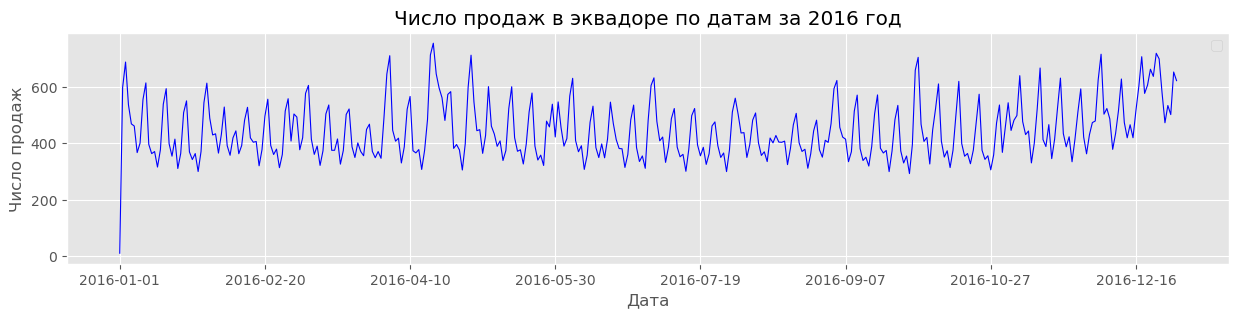

In [19]:
plotTimeSeries(data=trainDF, X="date", y="sales", xlabel="Дата", ylabel="Число продаж",
               title="Число продаж в эквадоре по датам за 2016 год", color="blue", linewidth=0.8);

### Проверка стационарности ряда

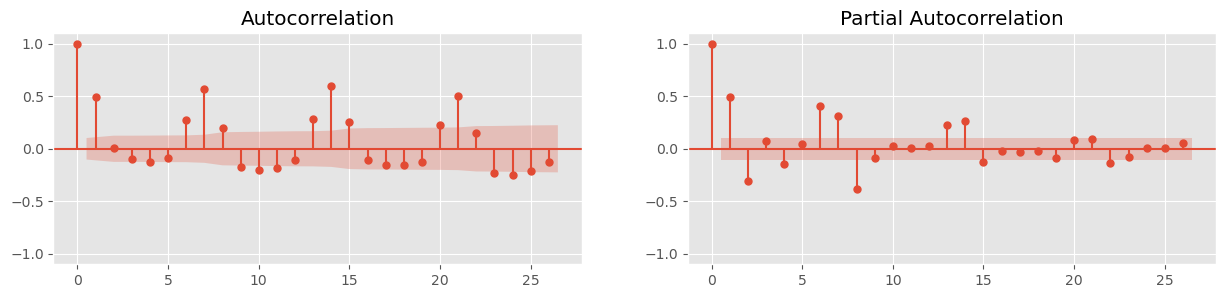

In [20]:
plotAcfPacf(data=trainDF, y="sales")

In [21]:
adf_test = adfuller(trainDF["sales"])
print(f"p-value: {adf_test[1]}")

p-value: 0.6865947009636304


In [22]:
trainDF.head(5)

,date,sales,onpromotion,dcoilwtico,transactions
0,2016-01-01,9.221882,0.089226,37.106277,1694.602158
1,2016-01-02,598.584414,1.028058,36.970000,1854.274794
2,2016-01-03,688.403883,1.647587,36.833723,1694.602158
3,2016-01-04,536.451670,0.976992,36.810000,1585.427525
4,2016-01-05,468.754455,2.216611,35.970000,1679.863003


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


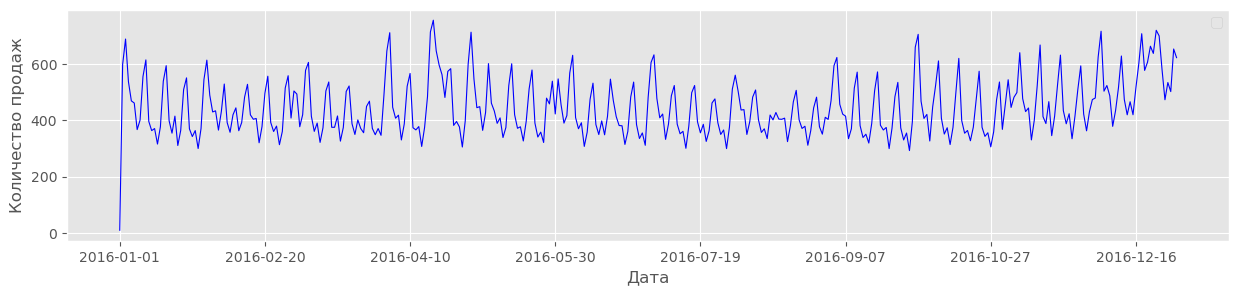

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax = plotTimeSeries(data=trainDF, X="date", y="sales", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="blue", title="", linewidth=0.8);

### Приведение ряда к стационарному

In [24]:
trainDF_new = trainDF.set_index("date").diff().fillna(0).reset_index()

In [25]:
trainDF_new.head(5)

,date,sales,onpromotion,dcoilwtico,transactions
0,2016-01-01,0.000000,0.000000,0.000000,0.000000
1,2016-01-02,589.362531,0.938833,-0.136277,159.672635
2,2016-01-03,89.819470,0.619529,-0.136277,-159.672635
3,2016-01-04,-151.952214,-0.670595,-0.023723,-109.174634
4,2016-01-05,-67.697214,1.239618,-0.840000,94.435478


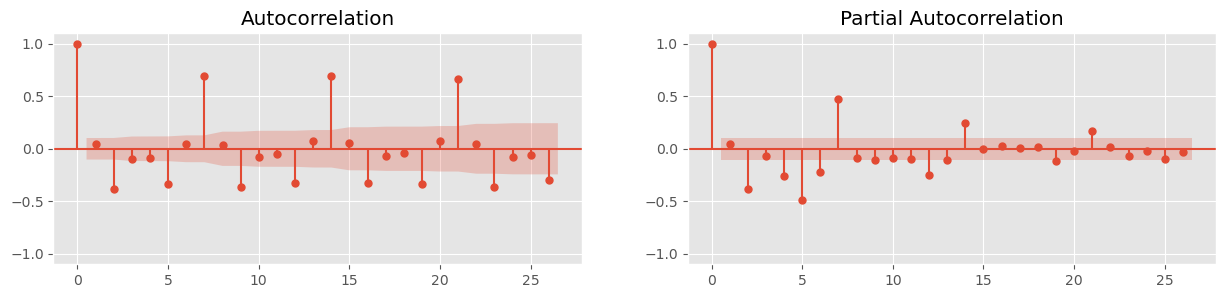

In [26]:
plotAcfPacf(data=trainDF_new, y="sales")

In [27]:
adf_test = adfuller(trainDF_new["sales"])
print(f"p-value: {adf_test[1]}")

p-value: 6.328231406694943e-14


### Наивный прогноз

In [28]:
train_size = int(trainDF["sales"].size * 0.8)
test_size  = trainDF["sales"].size - train_size

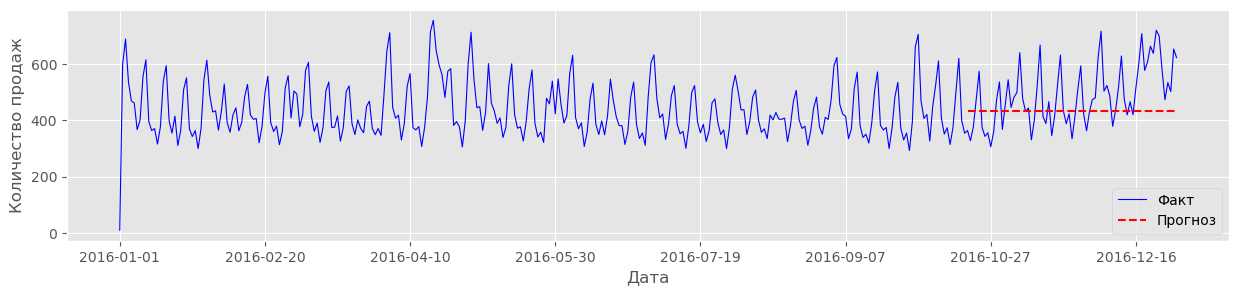

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

trainDF["forecast_naive"] = [None]*train_size + [trainDF.loc[train_size - train_size*0.8:train_size, "sales"].mean()] * test_size

ax = plotTimeSeries(data=trainDF, X="date", y="sales", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="blue", title="", label="Факт",
                    linewidth=0.8)

ax = plotTimeSeries(data=trainDF, X="date", y="forecast_naive", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="red", title="", label="Прогноз",
                    linestyle="--")

### Прогноз ARIMA

In [30]:
model = ARIMA(trainDF_new.loc[:train_size, "sales"], order=(2, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  293
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1791.210
Date:                Sun, 13 Oct 2024   AIC                           3588.420
Time:                        17:42:25   BIC                           3599.450
Sample:                             0   HQIC                          3592.838
                                - 293                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3611      0.053     -6.873      0.000      -0.464      -0.258
ar.L2         -0.5440      0.046    -11.716      0.000      -0.635      -0.453
sigma2      1.243e+04    838.558     14.827      0.0

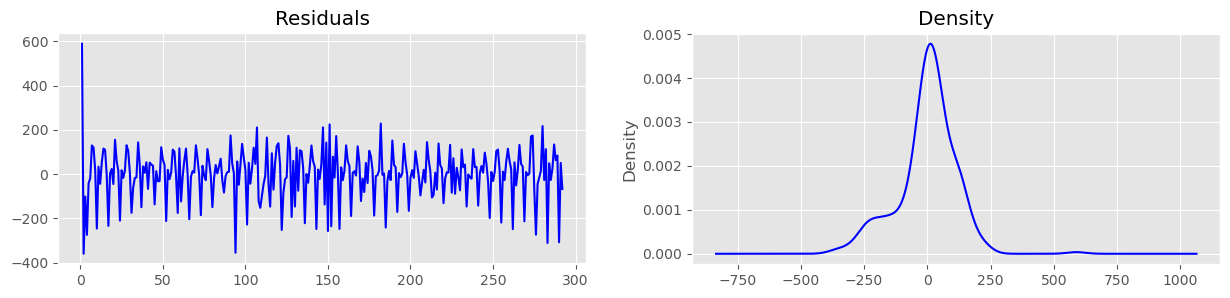

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

residuals = model_fit.resid[1:]

residuals.plot(title="Residuals", ax=ax[0], color="blue")
residuals.plot(title="Density", kind="kde", ax=ax[1], color="blue");

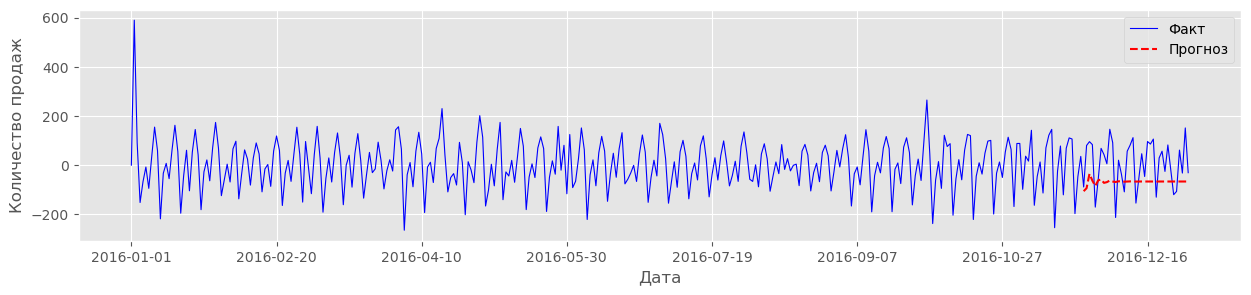

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

forecast_test = model_fit.forecast(test_size)
trainDF_new["forecast_manual"] = [None]*train_size + list(forecast_test)

ax = plotTimeSeries(data=trainDF_new, X="date", y="sales", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="blue", title="", label="Факт",
                    linewidth=0.8)

ax = plotTimeSeries(data=trainDF_new, X="date", y="forecast_manual", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="red", title="", label="Прогноз",
                    linestyle="--")

trainDF = trainDF.merge(trainDF_new[["date", "forecast_manual"]], on="date", how="left")

In [33]:

train_size = int(trainDF.shape[0] * 0.9)
test_size = trainDF.shape[0] - train_size

cols = ["onpromotion", "dcoilwtico", "transactions"]
X_train = trainDF.loc[:train_size, cols]
X_test = trainDF.loc[train_size:, cols]
y_train = trainDF.loc[:train_size, "sales"]
y_test = trainDF.loc[train_size:, "sales"]


In [34]:
model = SARIMAX(endog=y_train, exog=X_train).fit()
forecast = model.forecast(exog = X_test, steps=X_test.shape[0])

C:\Users\Maxim\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
trainDF["forecast_auto"] = [None]*train_size + list(forecast.values)

In [36]:
def plotTimeSeries(data: pd.DataFrame, X: str, y:str, axs = None, xlabel:str ="", ylabel:str ="",title:str="", **kwargs):

    if axs is not None:
        ax = axs
    else:
        fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    
    ax.plot(data[X], data[y],  **kwargs)
    ax.set_title(title)
    ax.set_xlabel(X if xlabel == "" else xlabel)
    ax.set_ylabel(y if ylabel == "" else ylabel)

    ax.xaxis.set_major_locator(plt.MaxNLocator(10))

    plt.grid(True)
    plt.legend()
    return ax

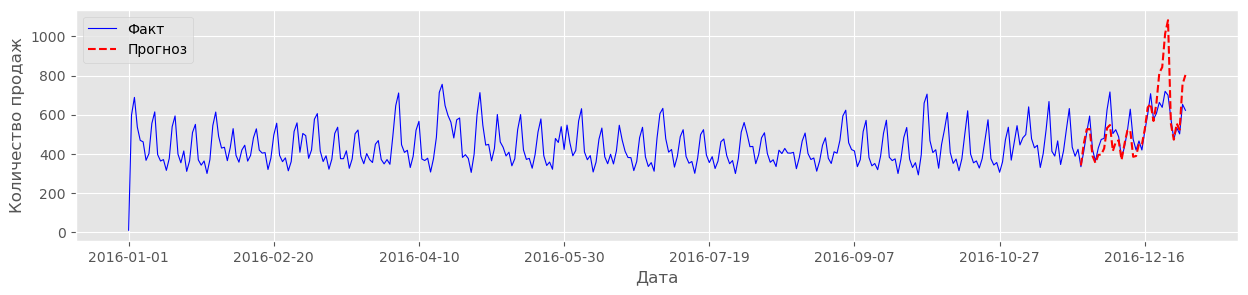

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax = plotTimeSeries(data=trainDF, X="date", y="sales", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="blue", title="", label="Факт",
                    linewidth=0.8)

ax = plotTimeSeries(data=trainDF, X="date", y="forecast_auto", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="red", title="", label="Прогноз",
                    linestyle="--")

### Прогнозирование ряда бустингом

In [38]:
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 3000, 7000, 500)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'learning_rate':  hp.loguniform('learning_rate', np.log(0.00001), np.log(1))
}

def objective(params):
    model = XGBRegressor(**params)

    cv_score = cross_val_score(model, X_train,
                               y_train, cv=3,
                               scoring='neg_mean_absolute_error').mean()

    return {'loss': -1*cv_score, 'params': params, 'status': STATUS_OK}

trials = Trials()
tpe_algo = tpe.suggest

best_params = fmin(fn=objective, space=space, algo=tpe_algo,
                   max_evals=100, trials=trials, verbose=1)

100%|███████████████████████████████████████████████| 100/100 [11:45<00:00,  7.05s/trial, best loss: 32.59144582689709]


In [39]:
best_params.update({"max_depth": int(best_params["max_depth"]),
                    "n_estimators": int(best_params["n_estimators"])})

In [40]:
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [41]:
trainDF["forecast_ml"] = [None]*train_size + list(prediction)
trainDF["prediction"] = [0] * train_size + [1] * test_size

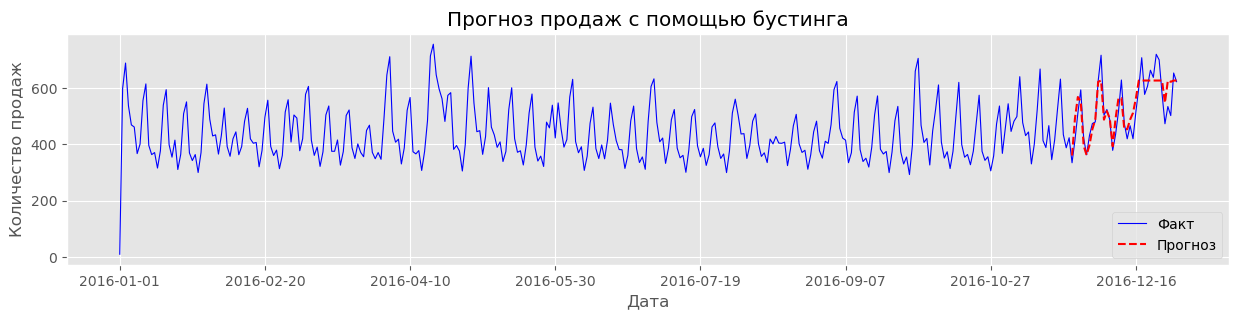

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax = plotTimeSeries(data=trainDF, X="date", y="sales", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="blue", title="", label="Факт",
                    linewidth=0.8)

ax = plotTimeSeries(data=trainDF, X="date", y="forecast_ml", axs=ax, xlabel="Дата",
                    ylabel="Количество продаж", color="red", title="Прогноз продаж с помощью бустинга", label="Прогноз",
                    linestyle="--")

### Сравнение результатов

In [49]:
errorsDf = trainDF.query("prediction == 1")
stats = (
    errorsCheck(errorsDf["sales"], errorsDf["forecast_manual"])
    .rename(columns={"value":"manual"})
    .merge(errorsCheck(errorsDf["sales"], errorsDf["forecast_auto"])
           .rename(columns={"value":"auto"}), on="metric")
    .merge(errorsCheck(errorsDf["sales"], errorsDf["forecast_ml"])
           .rename(columns={"value":"ml"}), on="metric")
    .merge(errorsCheck(errorsDf["sales"], errorsDf["forecast_naive"])
       .rename(columns={"value":"naive"}), on="metric")
)
stats

,metric,manual,auto,ml,naive
0,MSE,370425.063612,11849.563053,2761.131836,20720.685499
1,RMSE,608.625553,108.855698,52.546473,143.946815
2,MAE,600.125711,70.474641,42.322258,114.795845
3,Процентная ошибка,1.133873,0.117918,0.080065,0.196057


### Заключение

В работе решалась задача прогнозирования числа продаж в сети магазинов Эквадора. Было рассмотрено 3 способа прогнозирования:
* ARIMA модель с ручной настройкой параметров p, d b q;
* SARIMAX модель;
* Модель машинного обучения (градиентный бустинг).

Качество оценивалось с помощью следующих метрик: MSE, RMSE, MAE, абсолютная процентная ошибка. 
Результаты сравнивались с наивным прогнозом - срееднее число продаж за последнюю четверть тренировочного периода. Были получены следующие значения метрик:

| Метрика            | ARIMA         | SARIMAX      | XGBRegressor| Наивный прогноз |
|--------------------|---------------|--------------|-------------|-----------------|
| MSE                | 370425.063612 | 11849.563053 | 2761.131836 | 20720.685499    |
| RMSE               | 608.625553    | 108.855698   | 52.546473   | 143.946815      |
| MAE                | 600.125711    | 70.474641    | 42.322258   | 114.795845      |
| Процентная ошибка  | 1.133873      | 0.117918     | 0.080065    | 0.196057        |

По метрикам RMSE, MAE и процентной ошибке лучше всего себя показала ML модель. Второй по качеству оказалась SARIMAX модель. Полученные результаты можно объяснить тем, что ML модель имеет другую архитектуру (более сложный и тонкий процесс обучения), является более совершенной и новой, по сравнению с эконометрической моделью.
